In [1]:
from numpy.random import seed
seed(1)

Note: Due to GPU-related randomness, the training will not be reproducible.

In [2]:
import keras
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
tf.random.set_seed(10)

#### Load dataset from csv file.

In [3]:

df = pd.read_csv('./fake_or_real_news.csv')
df['merged_text'] = df['title'] + '. ' + df['text']
df.loc[df['label'] == 'REAL', 'target'] = 0
df.loc[df['label'] == 'FAKE', 'target'] = 1

df_pick = df[['merged_text', 'target']]
df.head()

,Unnamed: 0,title,text,label,merged_text,target
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,You Can Smell Hillary’s Fear. Daniel Greenfiel...,1.0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,1.0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy. U...,0.0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...,1.0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...,0.0


#### Load data as train and test data.   
  a. Add Title to Text and create the final text, label ordered pair.  
  b. Split the data 80-20 into train and test datasets.

In [4]:
training_data = df_pick.sample(frac=0.8, random_state=25)
testing_data = df_pick.drop(training_data.index)

print(training_data.shape)
print(testing_data.shape)

(5068, 2)
(1267, 2)


In [5]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_data['merged_text'].values, tf.string),
            tf.cast(training_data['target'].values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(testing_data['merged_text'].values, tf.string),
            tf.cast(testing_data['target'].values, tf.int32)
        )
    )
)
BUFFER_SIZE = 10000
BATCH_SIZE = 8
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2022-05-06 23:07:18.886064: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 23:07:20.804667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38334 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0


This is one training example in the dataset.

In [6]:
for example, label in training_dataset.take(1):
  print('texts: ', example.numpy()[:1])
  print('labels: ', label.numpy()[:1])

texts:  [b'\xe2\x80\x98People in Europe are full of fear\xe2\x80\x99 over refugee influx. The European Union\xe2\x80\x99s sharpening divisions over a spiraling refugee crisis broke into the open Thursday with two leaders strongly disagreeing in public over whether the asylum-seekers were threatening \xe2\x80\x9cEurope\xe2\x80\x99s Christian roots.\xe2\x80\x9d\n\nThat was the language used by Hungarian Prime Minister Viktor Orban as he warned Europe against allowing in mostly Muslim families. A day after a drowned Syrian toddler washed up on the Turkish coast, another European leader retorted that Christian values demanded helping the less fortunate.\n\nThe furious exchange \xe2\x80\x94 a rare breach of the E.U.\xe2\x80\x99s buttoned-down decorum \xe2\x80\x94 came as Hungarian authorities apparently laid a trap for thousands of asylum-seekers who had packed Budapest\xe2\x80\x99s central train station after days of worsening conditions outside the station. Police had blocked them from en

Note VOCAB_SIZE as a hyper-parameter. Next we create the Encoder layer that will encode every word in vocabulary as a vector.

#### Define the Encoder layer

In [7]:
VOCAB_SIZE = 2000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(training_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is',
       'for', 'on', 'as', 'it', 'with', 'he', 'was', 'are', 'be', 'this'],
      dtype='<U15')

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[   1,    7,  766, ...,    1,   11, 1545],
       [   1,    1, 1453, ...,    0,    0,    0],
       [ 732, 1260,  128, ...,    0,    0,    0]])

### Specify the model architecture
Layers:
1. Encoder
2. Embedding
3. LSTM
4. Dense layer
5. Output layer

In [27]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Sample prediction on untrained model

In [28]:
sample_text = ('''Poll: 71 percent of Dems think Clinton should keep running even if indicted. A strong majority of Democratic voters think Hillary 
               Clinton should keep running for president even if she is charged with 
               a felony in connection with her private email use while secretary of state, according to a new poll.''')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00443921]


### Training the model
First, we specify the loss, optimizer, and metrics for the training phase.

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

To implement Early Stopping, we monitor the Validation loss and do not stop training unless it doesn't decrease below current lowest for 7 epochs. Once it has stopped, we restore the model to its best weights according to the validation loss.

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(training_dataset, epochs=20, callbacks = [callback],
                    validation_data=test_dataset)

Epoch 1/20
634/634 [==============================] - 38s 60ms/step - loss: 0.3366 - accuracy: 0.8461 - val_loss: 0.3522 - val_accuracy: 0.8335
Epoch 2/20
634/634 [==============================] - 38s 60ms/step - loss: 0.2648 - accuracy: 0.8907 - val_loss: 0.4680 - val_accuracy: 0.7751
Epoch 3/20
634/634 [==============================] - 38s 60ms/step - loss: 0.3531 - accuracy: 0.8360 - val_loss: 0.3801 - val_accuracy: 0.8240
Epoch 4/20
634/634 [==============================] - 38s 60ms/step - loss: 0.2316 - accuracy: 0.9025 - val_loss: 0.4298 - val_accuracy: 0.8185
Epoch 5/20
634/634 [==============================] - 37s 59ms/step - loss: 0.1987 - accuracy: 0.9211 - val_loss: 0.4712 - val_accuracy: 0.7774
Epoch 6/20
634/634 [==============================] - 38s 60ms/step - loss: 0.2256 - accuracy: 0.8980 - val_loss: 0.5234 - val_accuracy: 0.7245
Epoch 7/20
634/634 [==============================] - 38s 60ms/step - loss: 0.2290 - accuracy: 0.9015 - val_loss: 0.3714 - val_accuracy:

### Results

In [46]:
def plot_graphs(history, metric):
    """Utility function to plot the graphs"""
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

The plots below show the training accuracy and loss alongside the validation (here, validation set is the test set itself) accuracy and loss, plotted against the epoch number.

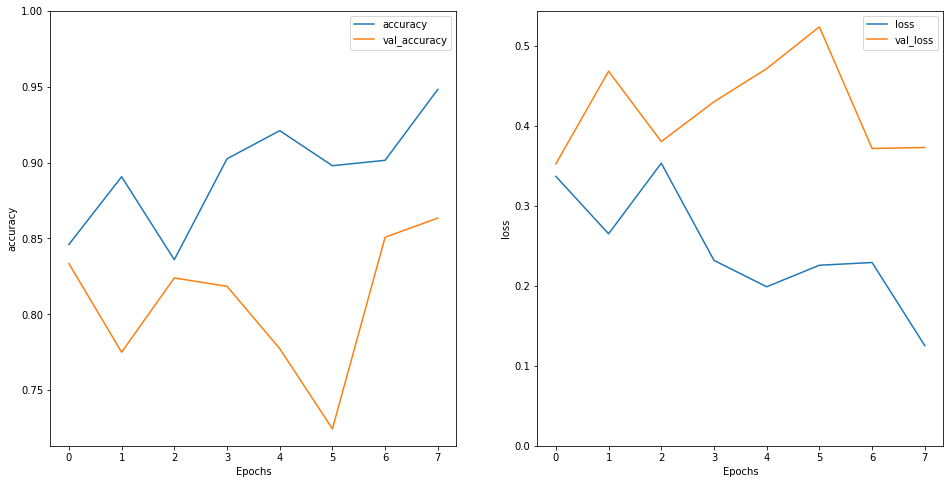

In [47]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig('plots/LSTM/LSTM_training')

### Test Loss and Accuracy of the trained LSTM classifier.

In [48]:
loss, accuracy =model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy}\nTest loss: {loss}')

159/159 [==============================] - 4s 23ms/step - loss: 0.3522 - accuracy: 0.8335
Test accuracy: 0.8334648609161377
Test loss: 0.3522043228149414
